In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [38]:
# Carregar o DataFrame
df = pd.read_excel('C:/Users/Patyc/OneDrive/Desktop/Dissertation/Data/Skin_clean and treated/Skin_clean.xlsx')

# Converter a data para datetime e ordenar de forma crescente
df['Screening_date'] = pd.to_datetime(df['Screening_date'])
df = df.sort_values(by='Screening_date')

df

,Screening_date,Gender,Age,Personal_cancer_history,Family_cancer_history,Sun_exposure,Body_signs,Premalignant,Malignant,Phototype_2,Phototype_3,Phototype_4,Phototype_5,Phototype_6
5901,2022-03-03,1.0,NaN,0.0,1.0,1.0,1.0,0,0,0,0,0,0,0
5895,2022-03-03,0.0,NaN,0.0,0.0,1.0,0.0,1,0,0,1,0,0,0
5896,2022-03-03,1.0,NaN,0.0,0.0,1.0,1.0,0,0,0,1,0,0,0
5897,2022-03-03,0.0,NaN,0.0,0.0,1.0,0.0,0,0,0,1,0,0,0
5898,2022-03-03,1.0,NaN,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4481,2024-04-27,0.0,23.0,0.0,0.0,1.0,0.0,0,0,0,1,0,0,0
4480,2024-04-27,1.0,81.0,1.0,0.0,1.0,1.0,0,1,1,0,0,0,0
4479,2024-04-27,1.0,59.0,1.0,1.0,0.0,1.0,0,1,1,0,0,0,0
8049,2024-04-27,1.0,63.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0


In [39]:
# Lista das colunas que deseja eliminar
columns_to_drop = [
    'Gender', 'Age', 'Personal_cancer_history', 'Family_cancer_history',
    'Sun_exposure', 'Body_signs', 'Premalignant', 'Malignant',
    'Phototype_2', 'Phototype_3', 'Phototype_4', 'Phototype_5', 'Phototype_6'
]

# Eliminar as colunas do DataFrame
df = df.drop(columns=columns_to_drop)

df

df.columns

Index(['Screening_date'], dtype='object')

In [40]:
# Criar as variáveis exógenas (VVs) diretamente a partir da data dos rastreios
df['Ano'] = df['Screening_date'].dt.year
df['Mês'] = df['Screening_date'].dt.month
df['Semana_do_Ano'] = df['Screening_date'].dt.isocalendar().week

df


,Screening_date,Ano,Mês,Semana_do_Ano
5901,2022-03-03,2022,3,9
5895,2022-03-03,2022,3,9
5896,2022-03-03,2022,3,9
5897,2022-03-03,2022,3,9
5898,2022-03-03,2022,3,9
...,...,...,...,...
4481,2024-04-27,2024,4,17
4480,2024-04-27,2024,4,17
4479,2024-04-27,2024,4,17
8049,2024-04-27,2024,4,17


In [41]:
# Criar a coluna 'Semana' para agrupar por semana
df['Semana'] = df['Screening_date'].dt.to_period('W').apply(lambda r: r.start_time)

# Agora agregue as VVs corretamente
df_week = df.groupby('Semana').agg({
    'Ano': 'first',                           # Ano da primeira ocorrência na semana
    'Mês': 'first',                           # Mês da primeira ocorrência na semana
    'Semana_do_Ano': 'first'                 # Semana do ano da primeira ocorrência na semana                  
}).reset_index()

# Adicionar a contagem de rastreios por semana
df_week['week_screenings'] = df.groupby('Semana')['Screening_date'].size().values

# Renomear a coluna 'Screening_date' para 'week_screenings'
df_week.rename(columns={'Screening_date': 'week_screenings'}, inplace=True)

# Remover as linhas onde week_screenings é igual a 0 (opcional)
df_week = df_week[df_week['week_screenings'] != 0]

df_week

,Semana,Ano,Mês,Semana_do_Ano,week_screenings
0,2022-02-28,2022,3,9,92
1,2022-03-14,2022,3,11,62
2,2022-03-21,2022,3,12,90
3,2022-04-04,2022,4,14,139
4,2022-04-18,2022,4,16,173
...,...,...,...,...,...
70,2024-03-18,2024,3,12,168
71,2024-03-25,2024,3,13,198
72,2024-04-01,2024,4,14,242
73,2024-04-15,2024,4,16,186


In [42]:
# Calcular variáveis adicionais após a agregação
df_week['Total_Cumulativo'] = df_week['week_screenings'].cumsum()
df_week['Diferença_Semanal'] = df_week['week_screenings'].diff().fillna(0)
df_week['Tendência_4_Semanas'] = df_week['week_screenings'].rolling(window=4).mean()

In [44]:
df_week

,Semana,Ano,Mês,Semana_do_Ano,week_screenings,Total_Cumulativo,Diferença_Semanal,Tendência_4_Semanas
0,2022-02-28,2022,3,9,92,92,0.0,NaN
1,2022-03-14,2022,3,11,62,154,-30.0,NaN
2,2022-03-21,2022,3,12,90,244,28.0,NaN
3,2022-04-04,2022,4,14,139,383,49.0,95.75
4,2022-04-18,2022,4,16,173,556,34.0,116.00
...,...,...,...,...,...,...,...,...
70,2024-03-18,2024,3,12,168,7584,-240.0,243.25
71,2024-03-25,2024,3,13,198,7782,30.0,243.00
72,2024-04-01,2024,4,14,242,8024,44.0,254.00
73,2024-04-15,2024,4,16,186,8210,-56.0,198.50


In [45]:
df_week.columns

Index(['Semana', 'Ano', 'Mês', 'Semana_do_Ano', 'week_screenings',
       'Total_Cumulativo', 'Diferença_Semanal', 'Tendência_4_Semanas'],
      dtype='object')

In [47]:
# Eliminar linhas que contenham qualquer valor NaN
df_week = df_week.dropna()

# Exibir o DataFrame resultante para verificar se as linhas foram removidas
print(df_week)


       Semana   Ano  Mês  Semana_do_Ano  week_screenings  Total_Cumulativo  \
3  2022-04-04  2022    4             14              139               383   
4  2022-04-18  2022    4             16              173               556   
5  2022-05-09  2022    5             19                3               559   
6  2022-05-23  2022    5             21               64               623   
7  2022-06-13  2022    6             24              101               724   
..        ...   ...  ...            ...              ...               ...   
70 2024-03-18  2024    3             12              168              7584   
71 2024-03-25  2024    3             13              198              7782   
72 2024-04-01  2024    4             14              242              8024   
73 2024-04-15  2024    4             16              186              8210   
74 2024-04-22  2024    4             17              184              8394   

    Diferença_Semanal  Tendência_4_Semanas  
3                4

In [48]:
df = df_week

In [49]:
df

,Semana,Ano,Mês,Semana_do_Ano,week_screenings,Total_Cumulativo,Diferença_Semanal,Tendência_4_Semanas
3,2022-04-04,2022,4,14,139,383,49.0,95.75
4,2022-04-18,2022,4,16,173,556,34.0,116.00
5,2022-05-09,2022,5,19,3,559,-170.0,101.25
6,2022-05-23,2022,5,21,64,623,61.0,94.75
7,2022-06-13,2022,6,24,101,724,37.0,85.25
...,...,...,...,...,...,...,...,...
70,2024-03-18,2024,3,12,168,7584,-240.0,243.25
71,2024-03-25,2024,3,13,198,7782,30.0,243.00
72,2024-04-01,2024,4,14,242,8024,44.0,254.00
73,2024-04-15,2024,4,16,186,8210,-56.0,198.50


CORRELAÇÃO ENTRE VVS

                          Ano       Mês  Semana_do_Ano  Total_Cumulativo  \
Ano                  1.000000 -0.598446      -0.590330          0.901199   
Mês                 -0.598446  1.000000       0.996399         -0.225500   
Semana_do_Ano       -0.590330  0.996399       1.000000         -0.212195   
Total_Cumulativo     0.901199 -0.225500      -0.212195          1.000000   
Diferença_Semanal    0.031358 -0.032550      -0.051424          0.004902   
Tendência_4_Semanas  0.350742 -0.178037      -0.168215          0.450151   

                     Diferença_Semanal  Tendência_4_Semanas  
Ano                           0.031358             0.350742  
Mês                          -0.032550            -0.178037  
Semana_do_Ano                -0.051424            -0.168215  
Total_Cumulativo              0.004902             0.450151  
Diferença_Semanal             1.000000             0.030347  
Tendência_4_Semanas           0.030347             1.000000  


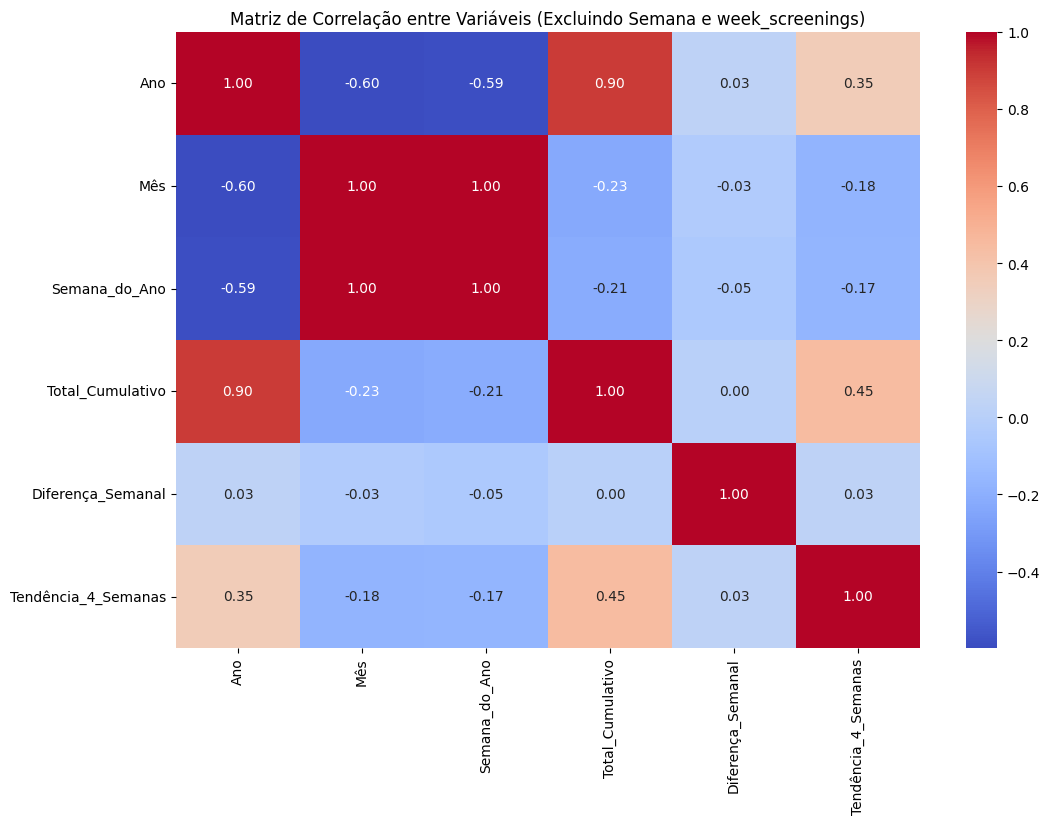

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Excluir as colunas 'Semana' e 'week_screenings' do DataFrame antes de calcular a correlação
df_filtered = df.drop(columns=['Semana', 'week_screenings'])

# Calcular a matriz de correlação
correlation_matrix = df_filtered.corr()

# Exibir a matriz de correlação
print(correlation_matrix)

# Visualizar a matriz de correlação com um heatmap
plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação entre Variáveis (Excluindo Semana e week_screenings)')
plt.show()


In [50]:
# Remove the 'Total_Cumulativo' column from df_week
df = df.drop(columns=['Total_Cumulativo'])

df

,Semana,Ano,Mês,Semana_do_Ano,week_screenings,Diferença_Semanal,Tendência_4_Semanas
3,2022-04-04,2022,4,14,139,49.0,95.75
4,2022-04-18,2022,4,16,173,34.0,116.00
5,2022-05-09,2022,5,19,3,-170.0,101.25
6,2022-05-23,2022,5,21,64,61.0,94.75
7,2022-06-13,2022,6,24,101,37.0,85.25
...,...,...,...,...,...,...,...
70,2024-03-18,2024,3,12,168,-240.0,243.25
71,2024-03-25,2024,3,13,198,30.0,243.00
72,2024-04-01,2024,4,14,242,44.0,254.00
73,2024-04-15,2024,4,16,186,-56.0,198.50


In [51]:
# Remove the 'Total_Cumulativo' column from df_week
df = df.drop(columns=['Mês'])

df

,Semana,Ano,Semana_do_Ano,week_screenings,Diferença_Semanal,Tendência_4_Semanas
3,2022-04-04,2022,14,139,49.0,95.75
4,2022-04-18,2022,16,173,34.0,116.00
5,2022-05-09,2022,19,3,-170.0,101.25
6,2022-05-23,2022,21,64,61.0,94.75
7,2022-06-13,2022,24,101,37.0,85.25
...,...,...,...,...,...,...
70,2024-03-18,2024,12,168,-240.0,243.25
71,2024-03-25,2024,13,198,30.0,243.00
72,2024-04-01,2024,14,242,44.0,254.00
73,2024-04-15,2024,16,186,-56.0,198.50


In [52]:
# Supondo que o DataFrame seja chamado 'df'
df = df.dropna()

df.head(75)

,Semana,Ano,Semana_do_Ano,week_screenings,Diferença_Semanal,Tendência_4_Semanas
3,2022-04-04,2022,14,139,49.0,95.75
4,2022-04-18,2022,16,173,34.0,116.00
5,2022-05-09,2022,19,3,-170.0,101.25
6,2022-05-23,2022,21,64,61.0,94.75
7,2022-06-13,2022,24,101,37.0,85.25
...,...,...,...,...,...,...
70,2024-03-18,2024,12,168,-240.0,243.25
71,2024-03-25,2024,13,198,30.0,243.00
72,2024-04-01,2024,14,242,44.0,254.00
73,2024-04-15,2024,16,186,-56.0,198.50


# MULTIPLE LINEAR REGRESSION MODEL

In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Assuming your DataFrame is named 'df'
X = df[['Ano', 'Semana_do_Ano', 'Diferença_Semanal', 'Tendência_4_Semanas']]
y = df['week_screenings']

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [54]:
# Assuming your DataFrame is named 'df' and has a date column named 'date'
df['Semana'] = pd.to_datetime(df['Semana'])

# Split the data into training and testing sets based on the date '2024-03-01'
train_df = df[df['Semana'] < '2024-03-11']
test_df = df[df['Semana'] >= '2024-03-11']

# Define X and y for both train and test sets
X_train = train_df[['Ano', 'Semana_do_Ano', 'Diferença_Semanal', 'Tendência_4_Semanas']]
y_train = train_df['week_screenings']

# Definir X e y para o conjunto de teste
X_test = test_df[['Ano', 'Semana_do_Ano', 'Diferença_Semanal', 'Tendência_4_Semanas']]
y_test = test_df['week_screenings']

In [21]:
# Create and fit the Linear Regression model
model_mlr = LinearRegression()
model_mlr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_mlr.predict(X_test)

In [24]:
# Calcular e imprimir as métricas de avaliação
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

print("Modelo: LR")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# split
# Modelo: LR
# MAE: 41.47971509311821
# MSE: 2329.9028323328844
# RMSE: 48.269067034001026
# R2: 0.6568794611458125





Modelo: LR
MAE: 41.47971509311821
MSE: 2329.9028323328844
RMSE: 48.269067034001026
R2: 0.6568794611458125
ME: -2.4839368150406265
MAV: 231.0
MPV: 0.1755480027293627
RME: -0.037038648097403815
RMAE: 0.1755480027293627


In [27]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import numpy as np

# Assuming your DataFrame is named 'df'
df['Semana'] = pd.to_datetime(df['Semana'])

# Add a constant manually to the dataset (a column of ones)
df['Constant'] = 1

# Define the features (including the manually added constant)
X = df[['Constant', 'Ano', 'Semana_do_Ano', 'Diferença_Semanal', 'Tendência_4_Semanas']]
y = df['week_screenings']

# Define cross-validation strategy respecting the time series nature of the data
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the MLR model
mlr = LinearRegression(fit_intercept=False)  # fit_intercept=False because we've added a constant manually

# Variables to store the best model's performance and parameters
best_mae = float('inf')
best_rmse = float('inf')
best_r2 = float('-inf')
best_model = None
best_fold_index = -1

# Perform cross-validation manually
for fold_index, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model on the training set
    mlr.fit(X_train, y_train)

    # Predict on the test set
    y_pred = mlr.predict(X_test)

    # Calculate MAE, RMSE, and R² for the current fold
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Print the fold performance
    print(f"Fold {fold_index + 1}: MAE = {mae:.4f}, RMSE = {rmse:.4f}, R² = {r2:.4f}")

    # Select the best model based on RMSE
    if rmse < best_rmse:  # You can choose to select based on RMSE
        best_mae = mae
        best_rmse = rmse
        best_r2 = r2
        best_model = mlr
        best_fold_index = fold_index

# Print the best model's performance and the corresponding fold
print(f"\nBest model selected from Fold {best_fold_index + 1}")
print(f"Best MAE: {best_mae:.4f}")
print(f"Best RMSE: {best_rmse:.4f}")
print(f"Best R²: {best_r2:.4f}")

# Optionally, fit the best model on the entire training set and evaluate on the test set
# Split the data into training and testing sets based on the date '2024-03-11'
train_df = df[df['Semana'] < '2024-03-11']
test_df = df[df['Semana'] >= '2024-03-11']

X_train = train_df[['Constant', 'Ano', 'Semana_do_Ano', 'Diferença_Semanal', 'Tendência_4_Semanas']]
y_train = train_df['week_screenings']

X_test = test_df[['Constant', 'Ano', 'Semana_do_Ano', 'Diferença_Semanal', 'Tendência_4_Semanas']]
y_test = test_df['week_screenings']

# Fit the best model on the full training set
best_model.fit(X_train, y_train)

# Predict and evaluate on the test set
y_pred_test = best_model.predict(X_test)

# Calculate MAE, RMSE, and R² on the test set
test_mae = mean_absolute_error(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_r2 = r2_score(y_test, y_pred_test)

print(f"\nTest Set Performance:")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R²: {test_r2:.4f}")

# spli 
# Test Set Performance:
# Test MAE: 41.4797
# Test RMSE: 48.2691
# Test R²: 0.6569


Fold 1: MAE = 18.7521, RMSE = 23.6241, R² = 0.4201
Fold 2: MAE = 24.7703, RMSE = 28.4538, R² = 0.4671
Fold 3: MAE = 42.6964, RMSE = 52.0779, R² = 0.7660
Fold 4: MAE = 17.1771, RMSE = 23.3683, R² = 0.8500
Fold 5: MAE = 36.7483, RMSE = 43.4466, R² = 0.7388

Best model selected from Fold 4
Best MAE: 17.1771
Best RMSE: 23.3683
Best R²: 0.8500

Test Set Performance:
Test MAE: 41.4797
Test RMSE: 48.2691
Test R²: 0.6569


# GLM MODEL

In [28]:
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Gaussian
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm

Kernel

In [55]:
# Definir o grau do polinômio
degree = 2

# Criar o transformador polinomial
poly = PolynomialFeatures(degree)

# Ajustar e transformar os dados de treino
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Adicionar uma constante aos dados transformados
X_train_poly_sm = sm.add_constant(X_train_poly)
X_test_poly_sm = sm.add_constant(X_test_poly)

# Ajustar o modelo GLM com família Gaussian
model_glm = GLM(y_train, X_train_poly_sm, family=Gaussian()).fit()

# Obter o resumo do modelo
print(model_glm.summary())

# Fazer previsões no conjunto de teste
y_pred = model_glm.predict(X_test_poly_sm)

# Calcular e imprimir as métricas de avaliação
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

                 Generalized Linear Model Regression Results                  
Dep. Variable:        week_screenings   No. Observations:                   66
Model:                            GLM   Df Residuals:                       52
Model Family:                Gaussian   Df Model:                           13
Link Function:               Identity   Scale:                          725.75
Method:                          IRLS   Log-Likelihood:                -303.16
Date:                Fri, 30 Aug 2024   Deviance:                       37739.
Time:                        16:47:04   Pearson chi2:                 3.77e+04
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9996
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.137e+08      9e+07     -1.263      0.2

In [56]:
print("Modelo: GLM com kernel polinomial")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# split
# Modelo: GLM com kernel polinomial
# MAE: 51.56257880401278
# MSE: 4084.7532116217208
# RMSE: 63.91207406759478
# R2: 0.39844584778041514



Modelo: GLM com kernel polinomial
MAE: 51.558553965205256
MSE: 4083.654327503453
RMSE: 63.903476646450564
R2: 0.3986076784394307
ME: 45.34567503579387
MAV: 231.0
MPV: 0.2210160793592056
RME: 0.1871361566655069
RMAE: 0.2210160793592056


In [59]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Gaussian
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Definir o grau do polinômio
degree = 2

# Criar o transformador polinomial
poly = PolynomialFeatures(degree)

# Ajustar e transformar os dados de treino
X_poly = poly.fit_transform(X)  # Transformando todos os dados disponíveis

# Adicionar uma constante aos dados transformados
X_poly_sm = sm.add_constant(X_poly)

# Definir o número de splits para a validação cruzada
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Listas para armazenar as métricas
mae_scores = []
rmse_scores = []
r2_scores = []

# Realizar a validação cruzada mantendo a sequência temporal
for train_index, test_index in tscv.split(X_poly_sm):
    X_train_cv, X_test_cv = X_poly_sm[train_index], X_poly_sm[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
    
    # Ajustar o modelo GLM com família Gaussian
    model_glm = GLM(y_train_cv, X_train_cv, family=Gaussian()).fit()
    
    # Fazer previsões no conjunto de teste atual
    y_pred_cv = model_glm.predict(X_test_cv)
    
    # Calcular MAE, RMSE e R²
    mae = mean_absolute_error(y_test_cv, y_pred_cv)
    rmse = np.sqrt(mean_squared_error(y_test_cv, y_pred_cv))
    r2 = r2_score(y_test_cv, y_pred_cv)
    
    # Armazenar as métricas
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

# Imprimir os scores de CV para cada métrica
print("Cross-Validation MAE Scores:", mae_scores)
print("Mean MAE:", np.mean(mae_scores))
print("Cross-Validation RMSE Scores:", rmse_scores)
print("Mean RMSE:", np.mean(rmse_scores))
print("Cross-Validation R2 Scores:", r2_scores)
print("Mean R2:", np.mean(r2_scores))

# Ajustar o modelo GLM no conjunto de dados completo
model_glm_final = GLM(y, X_poly_sm, family=Gaussian()).fit()

# Obter o resumo do modelo final
print(model_glm_final.summary())

# Fazer previsões no conjunto completo
y_pred_final = model_glm_final.predict(X_poly_sm)

# Calcular e imprimir as métricas no conjunto completo
mae_final = mean_absolute_error(y, y_pred_final)
rmse_final = np.sqrt(mean_squared_error(y, y_pred_final))
r2_final = r2_score(y, y_pred_final)

print("Final Model MAE:", mae_final)
print("Final Model RMSE:", rmse_final)
print("Final Model R2:", r2_final)

# Final Model MAE: 20.529916447099666
# Final Model RMSE: 26.03526438308516
# Final Model R2: 0.9106193039516082


Cross-Validation MAE Scores: [461.7538011660965, 56.87432382313076, 149.04240778549783, 53.219328725643685, 51.26843350848566]
Mean MAE: 154.43165900177087
Cross-Validation RMSE Scores: [556.3193403335907, 62.84718204027005, 189.56332820213638, 65.14674669100943, 59.68624772625587]
Mean RMSE: 186.71256899865247
Cross-Validation R2 Scores: [-320.5585876490304, -1.599636330394444, -2.1004608734239882, -0.16564981696899994, 0.5069669219582082]
Mean R2: -64.78347354957192
                 Generalized Linear Model Regression Results                  
Dep. Variable:        week_screenings   No. Observations:                   72
Model:                            GLM   Df Residuals:                       58
Model Family:                Gaussian   Df Model:                           13
Link Function:               Identity   Scale:                          841.45
Method:                          IRLS   Log-Likelihood:                -336.84
Date:                Fri, 30 Aug 2024   Deviance:    

features importances:

In [60]:
import pandas as pd
import numpy as np

# Supondo que 'model_glm_final' seja o seu modelo ajustado e 'poly' seja o objeto PolynomialFeatures

# Obter os coeficientes originais e seus valores absolutos
coefficients = model_glm_final.params
coefficients_abs = np.abs(coefficients)

# Normalizar os coeficientes absolutos de 0 a 100 para calcular a importância relativa
relative_importance = (coefficients_abs / coefficients_abs.max()) * 100

# Criar um DataFrame para organizar os coeficientes e as importâncias relativas
feature_importance = pd.DataFrame({
    'Feature': poly.get_feature_names_out(X.columns),  # Nomes das features após a transformação polinomial
    'Coefficient': coefficients,  # Coeficientes originais
    'Relative Importance': relative_importance  # Importância relativa normalizada
})

# Ordenar as features pela importância relativa
feature_importance = feature_importance.sort_values(by='Relative Importance', ascending=False)

# Exibir as importâncias relativas e os coeficientes
print(feature_importance)

# Salvar o DataFrame completo em um arquivo Excel
feature_importance.to_excel('feature_importance.xlsx', index=False)

print("Feature importance with coefficients has been saved to 'feature_importance.xlsx'.")



                                     Feature   Coefficient  \
const                                      1  4.011108e+07   
x1                                       Ano -3.972142e+04   
x2                             Semana_do_Ano  2.173983e+03   
x4                       Tendência_4_Semanas  8.220224e+02   
x3                         Diferença_Semanal  7.586503e+01   
x5                                     Ano^2  9.833845e+00   
x6                         Ano Semana_do_Ano -1.071768e+00   
x8                   Ano Tendência_4_Semanas -4.057847e-01   
x9                           Semana_do_Ano^2 -6.201193e-02   
x7                     Ano Diferença_Semanal -3.730148e-02   
x11        Semana_do_Ano Tendência_4_Semanas -3.513031e-02   
x10          Semana_do_Ano Diferença_Semanal  1.427258e-03   
x14                    Tendência_4_Semanas^2  1.344043e-03   
x12                      Diferença_Semanal^2  1.089949e-03   
x13    Diferença_Semanal Tendência_4_Semanas  3.240182e-04   

       

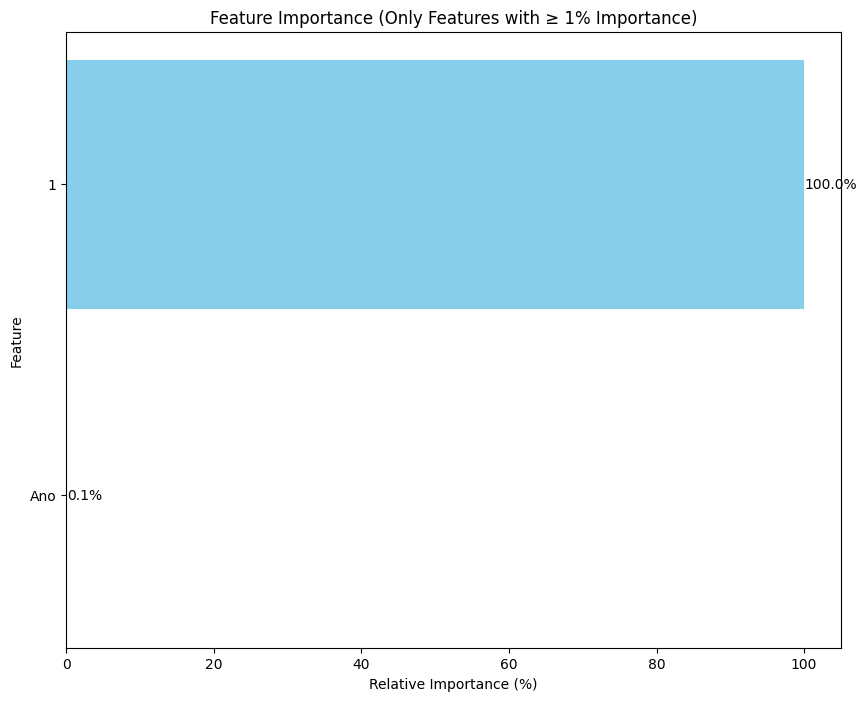

In [61]:
import matplotlib.pyplot as plt

# Filtrar as features que têm pelo menos 1% de importância relativa
filtered_features = feature_importance[feature_importance['Relative Importance'] >= 0.01]

# Ordenar as features filtradas por importância relativa
filtered_features = filtered_features.sort_values(by='Relative Importance', ascending=True)

# Criar o gráfico de barras horizontais
plt.figure(figsize=(10, 8))
plt.barh(filtered_features['Feature'], filtered_features['Relative Importance'], color='skyblue')

# Adicionar rótulos de porcentagem em cada barra
for index, value in enumerate(filtered_features['Relative Importance']):
    plt.text(value + 0.1, index, f"{value:.1f}%", va='center')

# Configurar títulos e labels
plt.xlabel('Relative Importance (%)')
plt.ylabel('Feature')
plt.title('Feature Importance (Only Features with ≥ 1% Importance)')

# Mostrar o gráfico
plt.show()


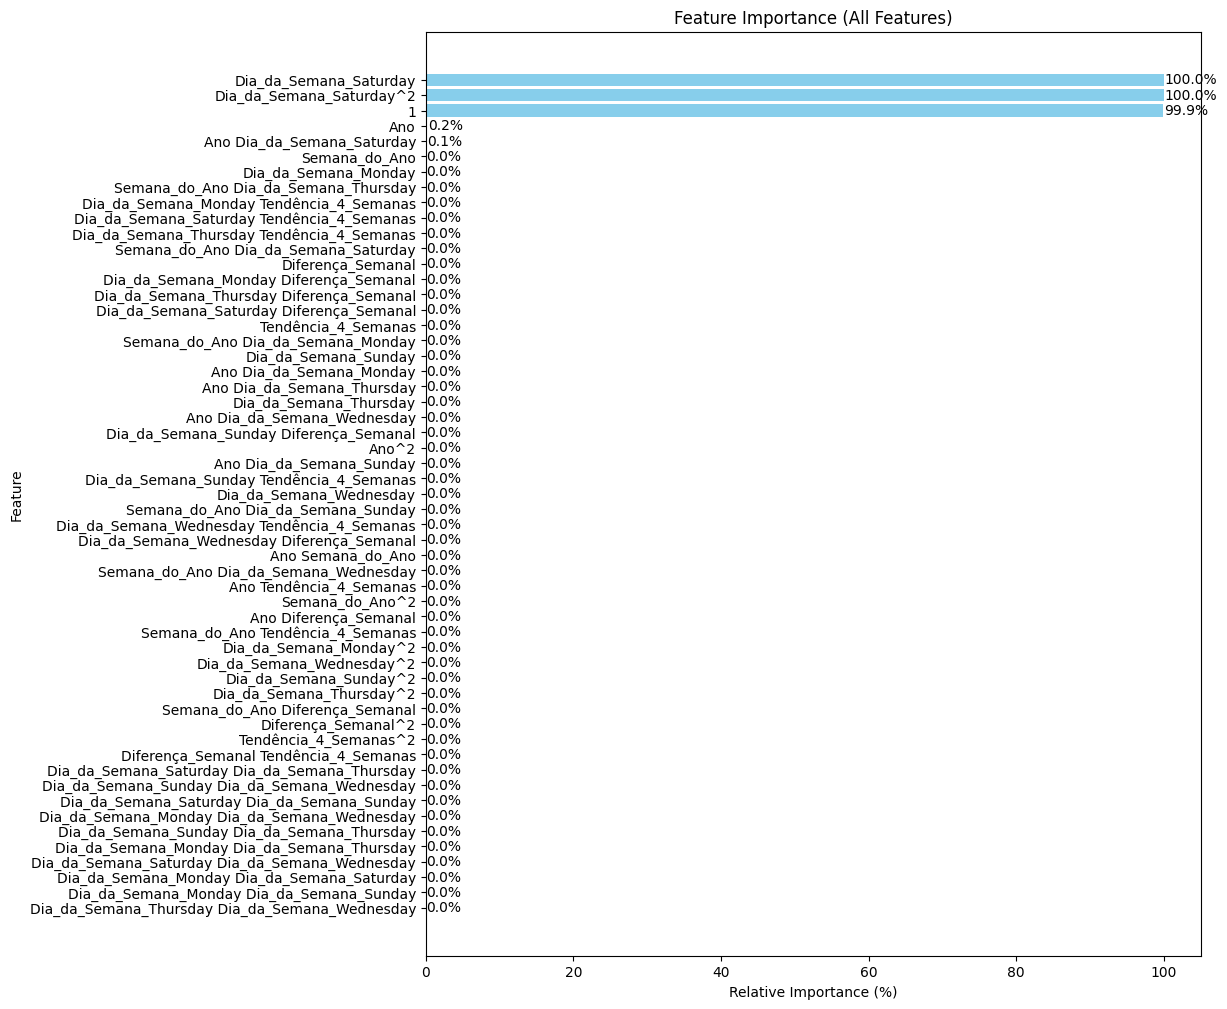

In [36]:
import matplotlib.pyplot as plt

# Ordenar as features por importância relativa
sorted_features = feature_importance.sort_values(by='Relative Importance', ascending=True)

# Criar o gráfico de barras horizontais para todas as features
plt.figure(figsize=(10, 12))
plt.barh(sorted_features['Feature'], sorted_features['Relative Importance'], color='skyblue')

# Adicionar rótulos de porcentagem em cada barra
for index, value in enumerate(sorted_features['Relative Importance']):
    plt.text(value + 0.1, index, f"{value:.1f}%", va='center')

# Configurar títulos e labels
plt.xlabel('Relative Importance (%)')
plt.ylabel('Feature')
plt.title('Feature Importance (All Features)')

# Mostrar o gráfico
plt.show()


SVR MODEL

In [106]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

Kernel gaussiano

In [107]:
# Definir o modelo SVR com kernel RBF
model_svr = SVR(kernel='rbf', C=1.0, gamma='scale')

# Ajustar o modelo
model_svr.fit(X_train, y_train)

# "Summary" of the model
print(f"Support Vectors: {model_svr.support_vectors_}")
print(f"Number of Support Vectors: {model_svr.n_support_}")
print(f"Dual Coefficients: {model_svr.dual_coef_}")

# Fazer previsões no conjunto de teste
y_pred = model_svr.predict(X_test)

# Calcular e imprimir as métricas de avaliação
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

Support Vectors: [[ 1.0000e+00  2.0220e+03  1.4000e+01  4.9000e+01  9.5750e+01]
 [ 1.0000e+00  2.0220e+03  1.6000e+01  3.4000e+01  1.1600e+02]
 [ 1.0000e+00  2.0220e+03  1.9000e+01 -1.7000e+02  1.0125e+02]
 [ 1.0000e+00  2.0220e+03  2.1000e+01  6.1000e+01  9.4750e+01]
 [ 1.0000e+00  2.0220e+03  2.4000e+01  3.7000e+01  8.5250e+01]
 [ 1.0000e+00  2.0220e+03  2.5000e+01 -1.8000e+01  6.2750e+01]
 [ 1.0000e+00  2.0220e+03  2.6000e+01  6.5000e+01  9.9000e+01]
 [ 1.0000e+00  2.0220e+03  2.7000e+01  5.8000e+01  1.3450e+02]
 [ 1.0000e+00  2.0220e+03  2.9000e+01 -1.1100e+02  1.3300e+02]
 [ 1.0000e+00  2.0220e+03  3.1000e+01 -9.0000e+00  1.3375e+02]
 [ 1.0000e+00  2.0220e+03  3.2000e+01  1.9200e+02  1.6625e+02]
 [ 1.0000e+00  2.0220e+03  3.3000e+01 -1.7600e+02  1.4025e+02]
 [ 1.0000e+00  2.0220e+03  3.6000e+01  8.1000e+01  1.6225e+02]
 [ 1.0000e+00  2.0220e+03  3.8000e+01 -8.4000e+01  1.6550e+02]
 [ 1.0000e+00  2.0220e+03  3.9000e+01  2.0000e+00  1.2125e+02]
 [ 1.0000e+00  2.0220e+03  4.1000e+01 

In [108]:
print("Modelo: SVR")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# Modelo: SVR shuffle
# MAE: 110.90723865119116
# MSE: 17318.33077454248
# RMSE: 131.59912907972637
# R2: -1.2815028949084608
# ME: 98.69759511702728
# MAV: 187.66666666666666
# MPV: 0.6246328362821879
# RME: 0.2900178062146467
# RMAE: 0.6246328362821879

# Modelo: SVR split
# MAE: 109.89232488225908
# MSE: 16987.299939558587
# RMSE: 130.33533649612673
# R2: -1.2378931603357781
# ME: 97.04360445447496
# MAV: 187.66666666666666
# MPV: 0.6248398252268327
# RME: 0.2770227763071711
# RMAE: 0.6248398252268327

# split 
# MAE: 140.31665050757888
# MSE: 26458.135021299488
# RMSE: 162.6595678750546
# R2: -2.896441267679469

Modelo: SVR
MAE: 140.31665050757888
MSE: 26458.135021299488
RMSE: 162.6595678750546
R2: -2.896441267679469
ME: 140.31665050757888
MAV: 231.0
MPV: 0.5709683500802721
RME: 0.5709683500802721
RMAE: 0.5709683500802721


Linear Kernel

In [109]:
# Definir o modelo SVR com kernel RBF
model_svr_linear = SVR(kernel='linear', C=1.0)

# Ajustar o modelo
model_svr_linear.fit(X_train, y_train)

# "Summary" of the model
print(f"Support Vectors: {model_svr_linear.support_vectors_}")
print(f"Number of Support Vectors: {model_svr_linear.n_support_}")
print(f"Dual Coefficients: {model_svr_linear.dual_coef_}")

# Fazer previsões no conjunto de teste
y_pred = model_svr_linear.predict(X_test)

# Calcular e imprimir as métricas de avaliação
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

Support Vectors: [[ 1.0000e+00  2.0220e+03  1.4000e+01  4.9000e+01  9.5750e+01]
 [ 1.0000e+00  2.0220e+03  1.6000e+01  3.4000e+01  1.1600e+02]
 [ 1.0000e+00  2.0220e+03  1.9000e+01 -1.7000e+02  1.0125e+02]
 [ 1.0000e+00  2.0220e+03  2.1000e+01  6.1000e+01  9.4750e+01]
 [ 1.0000e+00  2.0220e+03  2.4000e+01  3.7000e+01  8.5250e+01]
 [ 1.0000e+00  2.0220e+03  2.5000e+01 -1.8000e+01  6.2750e+01]
 [ 1.0000e+00  2.0220e+03  2.6000e+01  6.5000e+01  9.9000e+01]
 [ 1.0000e+00  2.0220e+03  2.7000e+01  5.8000e+01  1.3450e+02]
 [ 1.0000e+00  2.0220e+03  2.9000e+01 -1.1100e+02  1.3300e+02]
 [ 1.0000e+00  2.0220e+03  3.1000e+01 -9.0000e+00  1.3375e+02]
 [ 1.0000e+00  2.0220e+03  3.2000e+01  1.9200e+02  1.6625e+02]
 [ 1.0000e+00  2.0220e+03  3.3000e+01 -1.7600e+02  1.4025e+02]
 [ 1.0000e+00  2.0220e+03  3.6000e+01  8.1000e+01  1.6225e+02]
 [ 1.0000e+00  2.0220e+03  3.8000e+01 -8.4000e+01  1.6550e+02]
 [ 1.0000e+00  2.0220e+03  3.9000e+01  2.0000e+00  1.2125e+02]
 [ 1.0000e+00  2.0220e+03  4.1000e+01 

In [110]:
print("Modelo: SVR")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')


# Modelo: SVR
# MAE: 36.80114433649602
# MSE: 1993.3726587922117
# RMSE: 44.64720213845669
# R2: 0.737394697510277
# ME: -11.425072874576776
# MAV: 187.66666666666666
# MPV: 0.2267038474506203
# RME: -0.05520670526089726
# RMAE: 0.2267038474506203

# Modelo: SVR split
# MAE: 36.859693008474416
# MSE: 2079.6000961346977
# RMSE: 45.60263255706514
# R2: 0.7260351646269692
# ME: -14.145709093719226
# MAV: 187.66666666666666
# MPV: 0.220757854426049
# RME: -0.09248092230260839
# RMAE: 0.220757854426049

# split
# MAE: 47.20414432129877
# MSE: 3245.8568435706766
# RMSE: 56.97242178081143
# R2: 0.5219885852087758

Modelo: SVR
MAE: 47.20414432129877
MSE: 3245.8568435706766
RMSE: 56.97242178081143
R2: 0.5219885852087758
ME: -27.709750283927836
MAV: 231.0
MPV: 0.20622828091942524
RME: -0.15844790337684944
RMAE: 0.20622828091942524


In [28]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Definir os dados de treino e teste (assumindo que já foram preparados)
# X_train e y_train já foram definidos anteriormente

# Definir o modelo SVR com kernel linear
model_svr_linear = SVR(kernel='linear', C=1.0)

# Definir a estratégia de cross-validation temporal
tscv = TimeSeriesSplit(n_splits=5)

# Variáveis para armazenar os resultados das métricas em cada fold
mae_scores = []
rmse_scores = []
r2_scores = []
me_scores = []
mav_scores = []
mpv_scores = []
rme_scores = []
rmae_scores = []

# Realizar a validação cruzada mantendo a sequência temporal
for fold_index, (train_index, test_index) in enumerate(tscv.split(X_train)):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Ajustar o modelo ao conjunto de treino atual
    model_svr_linear.fit(X_train_fold, y_train_fold)

    # Fazer previsões no conjunto de teste
    y_pred_fold = model_svr_linear.predict(X_test_fold)

    # Calcular as métricas
    mae = mean_absolute_error(y_test_fold, y_pred_fold)
    mse = mean_squared_error(y_test_fold, y_pred_fold)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_fold, y_pred_fold)
    me = np.mean(y_test_fold - y_pred_fold)
    mav = np.mean(np.abs(y_test_fold))
    mpv = np.mean(np.abs((y_test_fold - y_pred_fold) / y_test_fold))
    rme = np.mean((y_test_fold - y_pred_fold) / y_test_fold)
    rmae = np.mean(np.abs(y_test_fold - y_pred_fold) / np.abs(y_test_fold))

    # Armazenar as métricas em listas
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    me_scores.append(me)
    mav_scores.append(mav)
    mpv_scores.append(mpv)
    rme_scores.append(rme)
    rmae_scores.append(rmae)

    # Printar os resultados de cada fold
    print(f"Fold {fold_index + 1}: MAE = {mae:.4f}, RMSE = {rmse:.4f}, R² = {r2:.4f}")

# Calcular as métricas médias ao final da cross-validation
mean_mae = np.mean(mae_scores)
mean_rmse = np.mean(rmse_scores)
mean_r2 = np.mean(r2_scores)
mean_me = np.mean(me_scores)
mean_mav = np.mean(mav_scores)
mean_mpv = np.mean(mpv_scores)
mean_rme = np.mean(rme_scores)
mean_rmae = np.mean(rmae_scores)

# Printar os resultados médios
print(f"\nCross-Validation Performance (Averages):")
print(f"Mean MAE: {mean_mae:.4f}")
print(f"Mean RMSE: {mean_rmse:.4f}")
print(f"Mean R²: {mean_r2:.4f}")
print(f"Mean ME: {mean_me:.4f}")
print(f"Mean MAV: {mean_mav:.4f}")
print(f"Mean MPV: {mean_mpv:.4f}")
print(f"Mean RME: {mean_rme:.4f}")
print(f"Mean RMAE: {mean_rmae:.4f}")

Fold 1: MAE = 25.4458, RMSE = 29.2485, R² = 0.1805
Fold 2: MAE = 29.6068, RMSE = 34.1687, R² = -0.0727
Fold 3: MAE = 40.3164, RMSE = 49.8711, R² = 0.7988
Fold 4: MAE = 23.4865, RMSE = 39.3740, R² = -0.1607
Fold 5: MAE = 29.1997, RMSE = 34.5755, R² = 0.8292

Cross-Validation Performance (Averages):
Mean MAE: 29.6110
Mean RMSE: 37.4476
Mean R²: 0.3150
Mean ME: -7.5151
Mean MAV: 97.9636
Mean MPV: 1.6949
Mean RME: -1.3921
Mean RMAE: 1.6949


# MLP NN MODEL

In [111]:
from sklearn.neural_network import MLPRegressor

In [112]:
# Definir o modelo MLP com uma camada oculta de 100 neurônios (você pode ajustar os parâmetros conforme necessário)
model_mlp = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)

# Ajustar o modelo aos dados de treino
model_mlp.fit(X_train, y_train)

# "Summary" do modelo
print(f"Coefs: {model_mlp.coefs_}")
print(f"Intercepts: {model_mlp.intercepts_}")
print(f"Número de iterações: {model_mlp.n_iter_}")

# Fazer previsões no conjunto de teste
y_pred = model_mlp.predict(X_test)

# Calcular e imprimir as métricas de avaliação
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

Coefs: [array([[-3.60812700e-02,  1.86928008e-01,  7.97301670e-02,
         2.35297319e-02, -1.93463949e-01, -1.29232293e-01,
        -1.73827901e-01,  1.47299522e-01,  2.70818506e-02,
         6.95178393e-02, -1.91099511e-01,  1.86713430e-01,
         1.90109582e-01, -1.66598752e-01, -1.21905505e-01,
        -1.21220678e-01, -1.22688675e-01,  4.24073339e-03,
        -2.21366729e-03, -6.93023747e-02,  2.45962873e-02,
        -2.01164546e-01, -6.94259226e-02, -3.92164635e-02,
        -8.87992352e-03,  1.02953322e-01, -1.63365665e-01,
         3.72832927e-02,  2.40088159e-02, -2.30145342e-01,
         2.94049496e-02, -1.22696882e-01, -1.70628320e-01,
         1.77031251e-01,  1.93583167e-01,  1.13265475e-01,
        -5.68128457e-02, -2.21056101e-01,  5.95322082e-02,
        -5.61312458e-02, -2.09842873e-01, -6.40430349e-04,
        -2.38342861e-01,  1.58890238e-01, -8.37123125e-02,
         5.06453771e-02, -5.83438227e-02,  4.12972436e-02,
         9.63012847e-03, -1.16278067e-01,  1.954

In [113]:
print("Modelo: MPL NN")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# Modelo: MPL NN shuffle
# MAE: 148.3347019043649
# MSE: 27076.336014730532
# RMSE: 164.54888639772233
# R2: -2.567014616208236
# ME: 146.82547236537584
# MAV: 187.66666666666666
# MPV: 0.7724405248428579
# RME: 0.7203981269466838
# RMAE: 0.7724405248428579

# Modelo: MPL NN
# MAE: 139.96906357741233
# MSE: 24353.79999190352
# RMSE: 156.05704082771632
# R2: -2.208349921646384
# ME: 137.2272955235615
# MAV: 187.66666666666666
# MPV: 0.7384680760467905
# RME: 0.6439243500519338
# RMAE: 0.7384680760467905

# split
# MAE: 35.840747183809775
# MSE: 4093.7468662876363
# RMSE: 63.98239497148912
# R2: 0.397121368668062

Modelo: MPL NN
MAE: 35.840747183809775
MSE: 4093.7468662876363
RMSE: 63.98239497148912
R2: 0.397121368668062
ME: 23.389912571568132
MAV: 231.0
MPV: 0.11540321121383196
RME: 0.050940101318252655
RMAE: 0.11540321121383196


# LSTM

In [126]:
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from sklearn.preprocessing import MinMaxScaler

In [127]:
# Normalizar os dados de entrada
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

# Redimensionar os dados para o formato [samples, timesteps, features]
# Como não temos uma série temporal específica, vamos usar a janela temporal de 1 (ou seja, cada amostra é seu próprio timestep)
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Dividir novamente os dados em treino e teste após a normalização
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

In [131]:
# Convertendo a coluna 'Semana' para datetime, se ainda não foi feito
df['Semana'] = pd.to_datetime(df['Semana'])

# Definir a data de corte para divisão de treino e teste
split_date = '2024-03-01'

# Criar conjuntos de treino e teste com base na data
train_indices = df['Semana'] < split_date
test_indices = df['Semana'] >= split_date

X_train = X_scaled[train_indices]
X_test = X_scaled[test_indices]
y_train = y[train_indices]
y_test = y[test_indices]

In [132]:
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Fazer previsões
y_pred = model.predict(X_test)

c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


In [133]:
# Flatten y_pred to make it a 1D array
y_pred = y_pred.flatten()

# Calcular e imprimir as métricas de avaliação
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

In [134]:
print("Modelo: LSTM")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# split
# MAE: 231.02939052383104
# MSE: 60165.80682230465
# RMSE: 245.28719253622813
# R2: -7.860507965087891
# ME: 231.02939052383104
# MAV: 231.0
# MPV: 1.000131884852717
# RME: 1.000131884852717
# RMAE: 1.000131884852717

# shuffle
# MAE: 187.7007750702401
# MSE: 42822.52245702975
# RMSE: 206.936034699203
# R2: -4.641404151916504
# ME: 187.7007750702401
# MAV: 187.66666666666666
# MPV: 1.0003038314357109
# RME: 1.0003038314357109
# RMAE: 1.0003038314357109

# split
# Modelo: LSTM
# MAE: 230.96035761137804
# MSE: 60133.64485094371
# RMSE: 245.22162394646952
# R2: -7.855772018432617

Modelo: LSTM
MAE: 230.96035761137804
MSE: 60133.64485094371
RMSE: 245.22162394646952
R2: -7.855772018432617
ME: 230.96035761137804
MAV: 231.0
MPV: 0.9998080812283657
RME: 0.9998080812283657
RMAE: 0.9998080812283657


# XGB MODEL

In [120]:
from xgboost import XGBRegressor

In [121]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[2])

In [122]:
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [123]:
# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)

# Calcular e imprimir as métricas de avaliação
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

In [124]:
print("Modelo: XGB")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# Modelo: XGB shuffle
# MAE: 73.98568153381348
# MSE: 7209.577884115871
# RMSE: 84.90923320885587
# R2: 0.05021613836288452
# ME: 68.51750831604004
# MAV: 187.66666666666666
# MPV: 0.40753031454348826
# RME: 0.3868808936660607
# RMAE: 0.40753031454348826

#split
# Modelo: XGB
# MAE: 39.60233052571615
# MSE: 2827.3205278721484
# RMSE: 53.172554272595825
# R2: 0.5836256742477417
# ME: 35.99457295735677
# MAV: 231.0
# MPV: 0.15086300530722507
# RME: 0.1312556272183154
# RMAE: 0.15086300530722507

# split
# Modelo: XGB
# MAE: 39.542442321777344
# MSE: 2712.928011430156
# RMSE: 52.085775519139155
# R2: 0.6004720330238342

Modelo: XGB
MAE: 39.542442321777344
MSE: 2712.928011430156
RMSE: 52.085775519139155
R2: 0.6004720330238342
ME: 36.87826792399088
MAV: 231.0
MPV: 0.1525773897886414
RME: 0.13809818110501934
RMAE: 0.1525773897886414
